In [43]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import utils

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


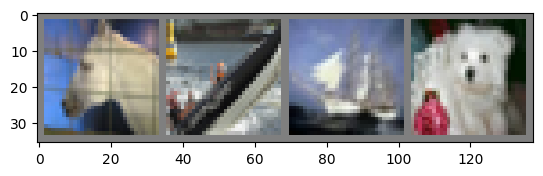

horse ship  ship  dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(3, 6, 5) # resize
        # nn.MaxPool2d(kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2) # max pool get max from 2x2 area
        self.conv2 = nn.Conv2d(6, 16, 5)
        # nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# weight_decay=0.0001 = 38%
# momentum = 0.9 = 56%
# both: 55%

net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [33]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.963
[1,  4000] loss: 1.697
[1,  6000] loss: 1.603
[1,  8000] loss: 1.524
[1, 10000] loss: 1.472
[1, 12000] loss: 1.427
[2,  2000] loss: 1.353
[2,  4000] loss: 1.359
[2,  6000] loss: 1.320
[2,  8000] loss: 1.344
[2, 10000] loss: 1.288
[2, 12000] loss: 1.282
Finished Training


In [7]:
PATH = './models/cifar_net_mom_wd.pth'
torch.save(net.state_dict(), PATH)

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

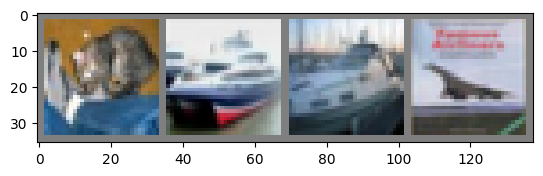

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.8 %
Accuracy for class: car   is 70.7 %
Accuracy for class: bird  is 49.1 %
Accuracy for class: cat   is 21.4 %
Accuracy for class: deer  is 61.3 %
Accuracy for class: dog   is 41.6 %
Accuracy for class: frog  is 67.1 %
Accuracy for class: horse is 50.3 %
Accuracy for class: ship  is 72.0 %
Accuracy for class: truck is 60.2 %


In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [41]:
net._modules['conv1'].weight.data

tensor([[[[ 1.2994e-01,  7.7775e-02,  1.3770e-01,  7.8497e-02,  6.4067e-02],
          [ 2.4236e-01,  2.1537e-01,  2.2839e-01,  2.4598e-01,  1.5320e-01],
          [ 1.7508e-01,  3.1796e-01,  2.8416e-01,  2.3488e-01,  2.3219e-01],
          [ 1.2587e-01,  8.0843e-02,  1.8230e-01,  1.6993e-01,  1.9234e-01],
          [ 6.2855e-02,  1.4819e-01,  1.4747e-01,  1.9797e-01,  8.0620e-03]],

         [[-1.3056e-01, -5.3381e-02, -8.9430e-03, -4.6198e-02,  3.5353e-02],
          [-1.8293e-01, -8.7239e-02, -5.3938e-02, -8.5900e-02, -6.3368e-02],
          [-1.5942e-01, -1.4529e-01, -1.2702e-01, -4.8936e-02, -1.4580e-02],
          [-1.1747e-01, -1.2089e-01, -6.8361e-02,  1.8698e-02, -5.3816e-02],
          [-8.4087e-02, -7.6725e-02, -1.9603e-01, -7.3046e-02, -4.9793e-02]],

         [[ 6.3809e-02,  1.1628e-01,  1.5742e-01,  2.4883e-01,  1.7345e-01],
          [-1.3412e-01, -9.7605e-02, -1.2041e-01,  3.0661e-02, -7.2338e-03],
          [-1.5470e-01, -1.6284e-01, -1.7180e-01, -9.3037e-02, -2.1358e-

torch.Size([6, 3, 5, 5])


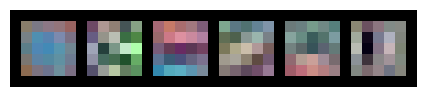

In [81]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        print(filter.shape)
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

torch.Size([16, 6, 5, 5])


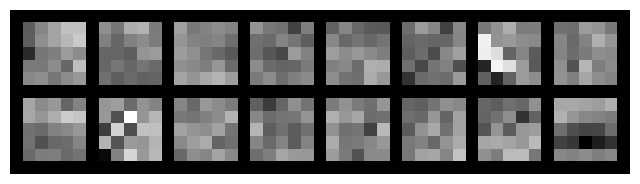

In [79]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv2'].weight.data.clone()
        print(filter.shape)
        visTensor(filter, ch=1, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

torch.Size([16, 6, 5, 5])


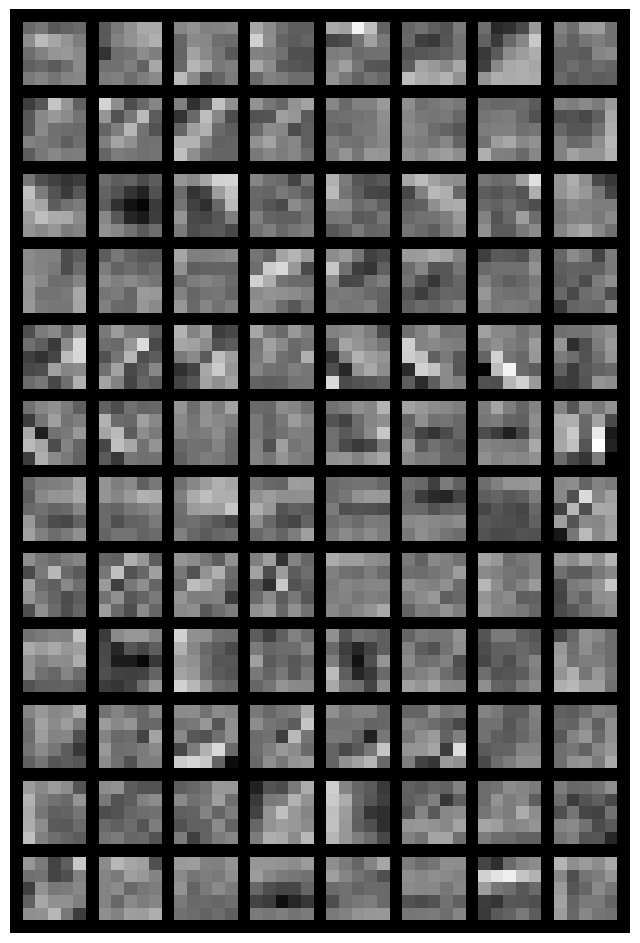

In [78]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv2'].weight.data.clone()
        print(filter.shape)
        visTensor(filter, ch=0, allkernels=True)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [53]:
net = Net()

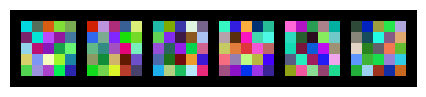

In [54]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.246
[1,  4000] loss: 1.931
[1,  6000] loss: 1.713
[1,  8000] loss: 1.616
[1, 10000] loss: 1.536
[1, 12000] loss: 1.482
Finished Training


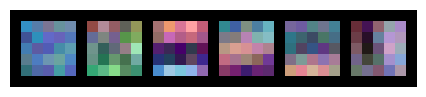

In [56]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [57]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.424
[1,  4000] loss: 1.404
[1,  6000] loss: 1.362
[1,  8000] loss: 1.338
[1, 10000] loss: 1.297
[1, 12000] loss: 1.265
Finished Training


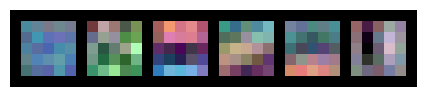

In [58]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        visTensor(filter, ch=0, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

In [59]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.233
[1,  4000] loss: 1.219
[1,  6000] loss: 1.197
[1,  8000] loss: 1.199
[1, 10000] loss: 1.198
[1, 12000] loss: 1.176
[2,  2000] loss: 1.097
[2,  4000] loss: 1.126
[2,  6000] loss: 1.112
[2,  8000] loss: 1.116
[2, 10000] loss: 1.109
[2, 12000] loss: 1.099
[3,  2000] loss: 1.013
[3,  4000] loss: 1.028
[3,  6000] loss: 1.052
[3,  8000] loss: 1.067
[3, 10000] loss: 1.050
[3, 12000] loss: 1.070
[4,  2000] loss: 0.945
[4,  4000] loss: 0.986
[4,  6000] loss: 0.991
[4,  8000] loss: 0.993
[4, 10000] loss: 1.008
[4, 12000] loss: 1.005
[5,  2000] loss: 0.910
[5,  4000] loss: 0.941
[5,  6000] loss: 0.951
[5,  8000] loss: 0.943
[5, 10000] loss: 0.959
[5, 12000] loss: 0.957
[6,  2000] loss: 0.844
[6,  4000] loss: 0.881
[6,  6000] loss: 0.935
[6,  8000] loss: 0.920
[6, 10000] loss: 0.910
[6, 12000] loss: 0.934
[7,  2000] loss: 0.815
[7,  4000] loss: 0.847
[7,  6000] loss: 0.878
[7,  8000] loss: 0.890
[7, 10000] loss: 0.888
[7, 12000] loss: 0.906
[8,  2000] loss: 0.784
[8,  4000] 

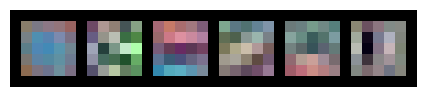

In [69]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        visTensor(filter, ch=3, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

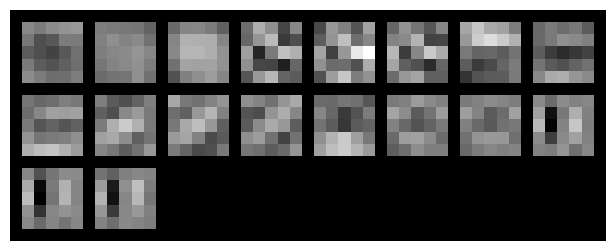

In [71]:
if __name__ == "__main__":
        layer = 1
        filter = net._modules['conv1'].weight.data.clone()
        visTensor(filter, ch=3, allkernels=True)

        plt.axis('off')
        plt.ioff()
        plt.show()